# 超参数与模型验证

在上一节中，我们介绍了有监督机器学习模型的基本步骤：
1. 选择模型类；
2. 选择模型超参数；
3. 用模型拟合训练数据；
4. 用模型预测新数据的标签。

前两步——模型选择和超参数选择——可能是有效使用各种机器学习工具和技术的最重要阶段。为了作出正确的选择，我们需要一种方式来**验证**选中的模型和超参数是否可以很好地拟合数据。  
这看起来是很简单，但要顺利地完成必须避过很多坑。

## 1. 什么是模型验证

模型验证（`model validation`）其实很简单，就是在选择模型和超参数之后，通过对训练数据进行学习，对比模型对已知数据的预测值与实际值的差异。  
在下面的几节中，我们首先通过一个简单方法实现模型验证，告诉你为什么那样做行不通。之后，介绍如何用留出集（`holdout set`）与交叉检验（`cross-validation`）实现更可靠的模型验证。

### 1.1. 错误的模型验证方法

In [1]:
# 让我们再用前面介绍过的鸢尾花数据来演示一个简单的模型验证方法。首先加载数据：
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

In [2]:
# 然后选择模型和超参数。这里使用一个 k 近邻分类器，超参数为 n_neighbors=1。这是一个非常简单直观的模型，“新数据的标签与其最接近的训练数据的标签相同”：
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=1)

In [3]:
# 然后训练模型，并用它来预测已知标签的数据：
model.fit(X, y)
y_model = model.predict(X)

In [4]:
# 最后，计算模型的准确率：
from sklearn.metrics import accuracy_score

accuracy_score(y, y_model)

1.0

准确得分是 `1.0`，也就是说模型识别标签的正确率是 `100%` ！但是这样测量的准确率可靠吗？我们真的有一个在任何时候准确率都是 `100%` 的模型吗？  
你可能已经猜到了，答案是否定的。其实这个方法有个根本缺陷：**它用同一套数据训练和评估模型**。另外，最近邻模型是一种**与距离相关**的评估器，只会简单地存储训练数据，然后把新数据与存储的已知数据进行对比来预测标签。在理想情况下，模型的准确率**总是** `100%`。

### 1.2. 模型验证正确方法：留出集

那怎么才能模型验证呢？其实**留出集**可以更好地评估模型性能，也就是说，先从训练模型的数据中留出一部分，然后用这部分留出来的数据来检验模型性能。  
在 `Scikit-Learn` 里面用 `train_test_split` 工具就可以实现：

In [6]:
# from sklearn.cross_validation import train_test_split  # ModuleNotFoundError: No module named 'sklearn.cross_validation'
from sklearn.model_selection import train_test_split

# 每个数据集分一半数据
X1, X2, y1, y2 = train_test_split(X, y, random_state=0, train_size=0.5)

# 用模型拟合训练数据
model.fit(X1, y1)

# 在测试集中评估模型准确率
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

这样就可以获得更合理的结果了：最近邻分类器在这份留出集上的准确率是 `90%`。这里的留出集类似新数据，因为模型之前没有“接触”过它们。

### 1.3. 交叉检验

用留出集进行模型验证有一个缺点，就是模型失去了一部分训练机会。在上面的模型中，有一半数据都没有为模型训练做出贡献。这显然不是最优解，而且可能还会出现问题——尤其是在训练数据集规模比较小的时候。  
解决这个问题的方法是**交叉检验**，也就是做一组拟合，让数据的每个子集既是训练集，又是验证集。用图形来说明的话，就如下图所示。  
![](../data/figures/05.03-2-fold-CV.png)

In [9]:
# 这里进行了两轮验证实验，轮流用一半数据作为留出集。如果还有前面的数据集，我们可以这样实现交叉检验：
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

这样就可以获得两个准确率，将二者结合（例如求均值）获取一个更准确的模型总体性能。这种形式的交叉检验被称为**两轮交叉检验**——将数据集分成两个子集，依次将每个子集作为验证集。  
可以通过扩展这个概念，在数据中实现更多轮的实验，例如下图是一个五轮交叉检验。  
![](../data/figures/05.03-5-fold-CV.png)

把数据分成五组，每一轮依次用模型拟合其中的四组数据，再预测第五组数据，评估模型准确率。手动实现这些过程会很无聊，用 `Scikit-Learn` 的 `cross_val_score` 函数可以非常简便地实现：

In [12]:
# from sklearn.cross_validation import cross_val_score # ModuleNotFoundError: No module named 'sklearn.cross_validation'
from sklearn.model_selection import cross_val_score

cross_val_score(model, X, y, cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

对数据的不同子集重复进行交叉检验，可以让我们对算法的性能有更好的认识。

`Scikit-Learn` 为不同应用场景提供了各种交叉检验方法，都以迭代器（`iterator`）形式在 `cross_validation` 模块中实现。  
例如，我们可能会遇到交叉检验的轮数与样本数相同的极端情况，也就是说我们每次只有一个样本做测试，其他样本全用于训练。  
这种交叉检验类型被称为 **LOO**（`leave-one-out`，只留一个）交叉检验，具体用法如下：

In [15]:
# from sklearn.cross_validation import LeaveOneOut # ModuleNotFoundError: No module named 'sklearn.cross_validation'
from sklearn.model_selection import LeaveOneOut

# scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X))) # TypeError: LeaveOneOut() takes no arguments
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [16]:
# 由于我们有 150 个样本，留一法交叉检验会生成 150 轮试验，每次试验的预测结果要么成功（得分 1.0），要么失败（得分 0.0）。计算所有试验准确率的均值就可以得到模型的预测准确性了：
scores.mean()

0.96

其他交叉检验机制的用法大同小异。

## 2. 选择最优模型

现在已经介绍了验证与交叉检验的基础知识，让我们更进一步，看看如何选择模型和超参数。这是机器学习实践中最重要的部分，但是许多机器学习入门教程都一笔带过了这些内容。  
关键问题是：**假如模型效果不好，应该如何改善？**答案可能有以下几种。
- 用更复杂 / 更灵活的模型。
- 用更简单 / 更确定的模型。
- 采集更多的训练样本。
- 为每个样本采集更多的特征。

问题的答案往往与直觉相悖。换一种更复杂的模型有时可能产生更差的结果，增加更多的训练样本也未必能改善性能！改善模型能力的高低，是区分机器学习实践者成功与否的标志。

### 2.1. 偏差与方差的均衡

“最优模型”的问题基本可以看成是找出**偏差**与**方差**平衡点的问题。下图显示的是对同一数据集拟合的两种回归模型。  
![](../data/figures/05.03-bias-variance.png)  
显然，这两个模型拟合得都不是很好，但它们的问题却是不一样的。  
左边的模型希望从数据中找到一条直线。但由于数据本质上比直线要复杂，直线永远不可能很好地描述这份数据。  
这样的模型被认为是对数据**欠拟合**；也就是说，模型没有足够的灵活性来适应数据的所有特征。另一种说法就是模型具有高**偏差**。  
右边的模型希望用高阶多项式拟合数据。虽然这个模型有足够的灵活性可以近乎完美地适应数据的所有特征，但与其说它是十分准确地描述了训练数据，不如说它是过多地学习了数据的噪音，而不是数据的本质属性。  
这样的模型被认为是对数据**过拟合**，也就是模型过于灵活，在适应数据所有特征的同时，也适应了随机误差。另一种说法就是模型具有高**方差**。

现在再换个角度，如果用两个模型分别预测 `y` 轴的数据，看看是什么效果。在下图中，浅红色的点是被预测数据集遗漏的点。  
![](../data/figures/05.03-bias-variance-2.png)  
这个分数是 `R2`，也称为判定系数（<https://en.wikipedia.org/wiki/Coefficient_of_determination>），用来衡量模型与目标值均值的对比结果。  
`R2 = 1` 表示模型与数据完全吻合，`R2 = 0` 表示模型不比简单取均值好，`R2` 为负表示模型性能很差。从这两个模型的得分可以得出两条一般性的结论。  
- 对于高偏差模型，模型在验证集的表现与在训练集的表现类似。
- 对于高方差模型，模型在验证集的表现远远不如在训练集的表现。

**如果我们有能力不断调整模型的复杂度，那么我们可能希望训练得分和验证得分如下图所示。**  
下图通常被称为验证曲线，具有以下特征。  
- 训练得分肯定高于验证得分。一般情况下，模型拟合自己接触过的数据，比拟合没接触过的数据效果要好。
- 使用复杂度较低的模型（高偏差）时，训练数据往往欠拟合，说明模型对训练数据和新数据都缺乏预测能力。
- 而使用复杂度较高的模型（高方差）时，训练数据往往过拟合，说明模型对训练数据预测能力很强，但是对新数据的预测能力很差。
- 当使用复杂度适中的模型时，验证曲线得分最高。说明在该模型复杂度条件下，偏差与方差达到均衡状态。  
![](../data/figures/05.03-validation-curve.png)

不同模型复杂度的调整方法大不相同。后文在深入介绍各种模型时，就会讲解每种模型的调整方法。

### 2.2. Scikit-Learn验证曲线

下面来看一个例子，用交叉检验计算一个模型的验证曲线。这里用**多项式回归**模型，它是线性回归模型的一般形式，其多项式的次数是一个可调参数。  
例如，多项式次数为 `1` 其实就是将数据拟合成一条直线。若模型有参数 `a` 和 `b`，则模型为：y = ax + b   
多项式次数为 `3`，则是将数据拟合成一条三次曲线。若模型有参数 `a`、`b`、`c`、`d`，则模型为：y = ax<sup>3</sup> + bx<sup>2</sup> + cx +d  
推而广之，就可以得到任意次数的多项式。  
在 `Scikit-Learn` 中，可以用一个带多项式预处理器的简单线性回归模型实现。我们将用一个**管道命令**来组合这两种操作：

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

In [19]:
# 现在来创造一些数据给模型拟合：
import numpy as np

def make_data(N, err=1.0, rseed=1):
    # 随机轴样数据
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

X, y = make_data(40)

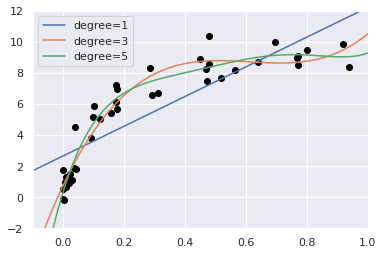

In [20]:
# 通过数据可视化，将不同次数的多项式拟合曲线画出来，如下图所示：
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y, color='black')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best')

这个例子中控制模型复杂度的关键是多项式的次数，它只要是非负整数就可以。那么问题来了：究竟多项式的次数是多少，才能在偏差（欠拟合）与方差（过拟合）间达到平衡？

我们可以通过可视化验证曲线来回答这个问题——利用 `Scikit-Learn` 的 `validation_curve` 函数就可以非常简单地实现。  
只要提供模型、数据、参数名称和验证范围信息，函数就会自动计算验证范围内的训练得分和验证得分，如下图所示：

Text(0, 0.5, 'score')

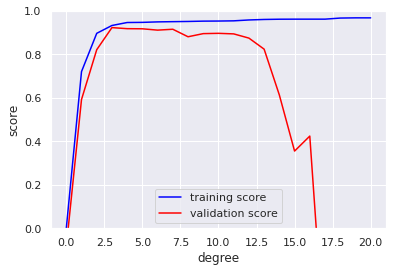

In [26]:
# from sklearn.learning_curve import validation_curve  # ModuleNotFoundError: No module named 'sklearn.learning_curve'
from sklearn.model_selection import validation_curve

degree = np.arange(0, 21)
# TypeError: validation_curve() takes 3 positional arguments but 5 positional arguments (and 1 keyword-only argument) were given
# train_score, val_score = validation_curve(PolynomialRegression(), X, y, 'polynomialfeatures__degree', degree, cv=7)
train_score, val_score = validation_curve(PolynomialRegression(), X, y, param_name='polynomialfeatures__degree', param_range=degree, cv=7)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

## 3. 学习曲线

### 3.1. Scikit-Learn学习曲线

## 4. 验证实践：网格搜索